In [2]:
import pandas as pd


In [4]:
import pandas as pd

df = pd.read_csv("blood_pressure_data.csv")
df.head()


,Date,Time,Patient First Name,Patient Last Name,PCP,Clinic Visit Provider,Clinic,Systolic BP reading,Diastolc BP reading
0,6/23/2021,11:41:00 AM,A,A,Dr. Clark,Dr. Clark,GIM,149,89
1,10/26/2021,1:45:00 PM,A,A,Dr. Clark,Dr. Basit,Parkland Cardiology,141,64
2,9/11/2021,1:05:00 PM,C,A,Dr. Clark,Dr. Basit,UTSW Cardiology,110,67
3,9/11/2021,1:07:00 PM,C,A,Dr. Clark,Dr. Basit,UTSW Cardiology,110,63
4,1/15/2021,10:33:00 AM,G,A,Dr. Fish,Dr. Basit,Parkland Cardiology,168,103


In [21]:
# misspelled column
df = df.rename(columns={"Diastolc BP reading": "Diastolic BP reading"})


In [22]:
df.columns


Index(['Date', 'Time', 'Patient First Name', 'Patient Last Name', 'PCP',
       'Clinic Visit Provider', 'Clinic', 'Systolic BP reading',
       'Diastolic BP reading', 'Patient_ID', 'BP_Category', 'is_elevated'],
      dtype='str')

In [23]:
df.shape


(154, 12)

In [24]:
df.isna().sum()


Date                     0
Time                     0
Patient First Name       0
Patient Last Name        0
PCP                      0
Clinic Visit Provider    0
Clinic                   0
Systolic BP reading      0
Diastolic BP reading     0
Patient_ID               0
BP_Category              0
is_elevated              0
dtype: int64

In [25]:
# create a pt ID
df["Patient_ID"] = df["Patient First Name"] + "_" + df["Patient Last Name"]

df["Patient_ID"].head()


0    A_A
1    A_A
2    C_A
3    C_A
4    G_A
Name: Patient_ID, dtype: str

In [27]:
# categorize blood pressure and define normal, high or low
def bp_category(sbp, dbp):
    if (sbp < 90) or (dbp < 60):
        return "Low"
    if (sbp >= 130) or (dbp >= 80):
        return "Elevated"
    return "Normal"

df["BP_Category"] = df.apply(
    lambda row: bp_category(row["Systolic BP reading"], row["Diastolic BP reading"]),
    axis=1
)

df["BP_Category"].value_counts()



BP_Category
Elevated    101
Low          40
Normal       13
Name: count, dtype: int64

In [28]:
# Identify elevated readings
df["is_elevated"] = df["BP_Category"] == "Elevated"

# Group by patient and check if they EVER had an elevated reading
patient_elevated = (
    df.groupby("Patient_ID")["is_elevated"]
      .any()
)

total_patients = df["Patient_ID"].nunique()
elevated_patients = patient_elevated.sum()

print("Total patients:", total_patients)
print("Patients with ≥1 elevated reading:", elevated_patients)
print("Percent elevated:", round(100 * elevated_patients / total_patients, 1), "%")


Total patients: 74
Patients with ≥1 elevated reading: 58
Percent elevated: 78.4 %


## Part 1: How Many Patients Have Elevated Blood Pressure?

Blood pressure readings were categorized as Low, Normal, or Elevated using predefined systolic and diastolic thresholds. 

A patient was considered to have elevated blood pressure if they had at least one reading categorized as "Elevated." 

After grouping readings by patient and checking whether each patient ever had an elevated reading:

- Total unique patients: 74  
- Patients with ≥1 elevated reading: 58  
- Percent of patients with elevated blood pressure: 78.4%

This analysis moves from reading-level data to patient-level classification by using a group-by operation and checking whether any elevated readings occurred for each patient.


In [29]:
# create a visualization for elevated BP, interested in pt with uncontrolled BP
# Calculate percent elevated readings per patient
patient_summary = (
    df.groupby("Patient_ID")["is_elevated"]
      .mean()
      .reset_index()
)

patient_summary.columns = ["Patient_ID", "Percent_Elevated"]

patient_summary.sort_values("Percent_Elevated", ascending=False).head()



,Patient_ID,Percent_Elevated
0,A_A,1.0
3,A_H,1.0
8,B_D,1.0
4,A_I,1.0
5,A_J,1.0


In [30]:
example_patient = patient_summary.sort_values(
    "Percent_Elevated",
    ascending=False
)["Patient_ID"].iloc[0]

example_patient


'A_A'

In [31]:
patient_df = df[df["Patient_ID"] == example_patient].copy()


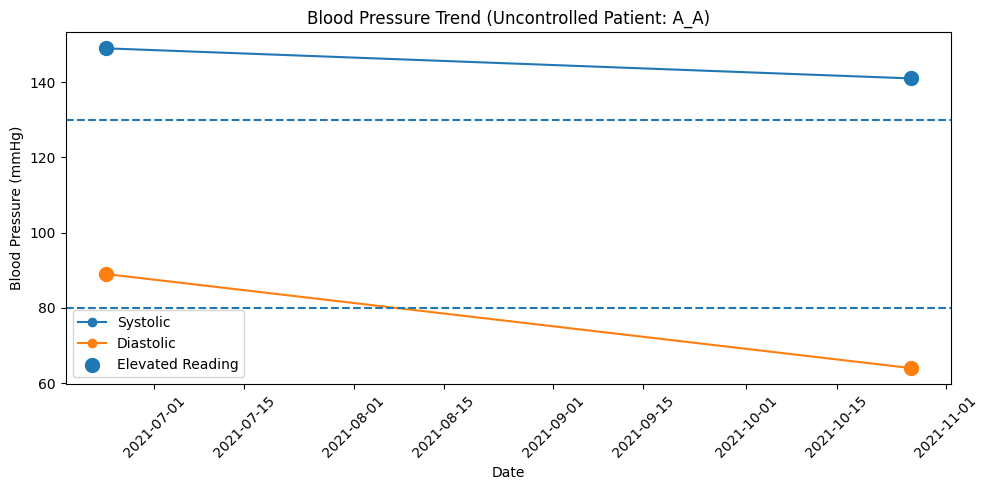

In [ ]:
# visualization single pt with elevated BP that is more uncontrolled
import matplotlib.pyplot as plt
import pandas as pd

# Ensure DateTime column exists
patient_df["DateTime"] = pd.to_datetime(
    patient_df["Date"] + " " + patient_df["Time"]
)

patient_df = patient_df.sort_values("DateTime")

plt.figure(figsize=(10,5))

# Plot systolic and diastolic trends
plt.plot(
    patient_df["DateTime"],
    patient_df["Systolic BP reading"],
    marker="o",
    label="Systolic"
)

plt.plot(
    patient_df["DateTime"],
    patient_df["Diastolic BP reading"],
    marker="o",
    label="Diastolic"
)

# Highlight elevated readings
elevated_points = patient_df[patient_df["BP_Category"] == "Elevated"]

plt.scatter(
    elevated_points["DateTime"],
    elevated_points["Systolic BP reading"],
    s=100,
    zorder=5,
    label="Elevated Reading"
)

plt.scatter(
    elevated_points["DateTime"],
    elevated_points["Diastolic BP reading"],
    s=100,
    zorder=5
)

# Optional reference lines for interpretation
plt.axhline(130, linestyle="--")
plt.axhline(80, linestyle="--")

plt.title(f"Blood Pressure Trend (Uncontrolled Patient: {example_patient})")
plt.xlabel("Date")
plt.ylabel("Blood Pressure (mmHg)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



## Part 2: Single Patient Visualization

A patient with the highest proportion of elevated readings (100%) was selected to represent uncontrolled blood pressure.

A time-series line chart was used to display systolic and diastolic blood pressure over time. Elevated readings were highlighted and clinical reference thresholds (130 mmHg systolic and 80 mmHg diastolic) were included for interpretation.

Strengths:
- Displays trends over time
- Clearly identifies persistent elevation
- Clinically intuitive format

Weaknesses:
- Does not account for medication changes
- Limited number of observations
- Does not assess long-term control patterns
